# Autoencoders

This notebook walks you through different design choices for AutoEncoders, 
pretraining models with unsupervised learning (proxy tasks), and evaluating
the learned representations with a linear classifier. In particular, we examine
the following architectures:
1.  Vanilla Autoencoder
2.  Denoising Autoencoder
3.  Masked Autoencoder

Fill in the ```TODOs``` in the notebook to run experiments, report your findings
in the written assignment. 

In [ ]:
import numpy as np
import torch
import torchvision
from torch import nn, optim

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_style('whitegrid')

In [ ]:

class SyntheticDataset:
    """
    Create a torch compatible dataset by sampling 
    features from a multivariate normal distribution with 
    specified mean and covariance matrix. In particular,
    the covariance is high along a small fraction of the directions.
    """
    def __init__(self,
                 input_size,
                 samples=10000,
                 splits=None,
                 num_high_var_dims=2,
                 var_scale=100,
                 batch_size=100):
        """
        input_size: (int) size of inputs
        samples: (int) number of samples to generate
        splits: list(float) of splitting dataset for [#train, #valid, #test]
        num_high_var_dims : (int) #dimensions with scaled variance
        var_scale : (float)
        """
        train_split, valid_split, test_split = splits
        self.input_size = input_size
        self.samples = samples
        self.num_high_var_dims = num_high_var_dims
        self.var_scale = var_scale
        self.batch_size = batch_size
        self.num_train_samples = int(samples * train_split)
        self.num_valid_samples = int(samples * valid_split)
        self.num_test_samples = int(samples * test_split)
        self._build()
    
    def _build(self):
        """
        Covariance is scaled along num_high_var_dims. 
        Create torch compatible dataset.
        """
        self.mean = np.zeros(self.input_size)
        self.cov = np.eye(self.input_size)
        self.cov[:self.num_high_var_dims, :self.num_high_var_dims] *= self.var_scale
        self.X = np.random.multivariate_normal(self.mean, self.cov, self.samples)

        # generate random rotation matrix with SVD
        u, _, v = np.linalg.svd(np.random.randn(self.input_size, self.input_size))
        sample = self.X @ u

        # create classification labels that depend only on the high-variance dimensions
        target = self.X[:, :self.num_high_var_dims].sum(axis=1) > 0

        self.train_sample = torch.from_numpy(sample[:self.num_train_samples]).float()
        self.train_target = torch.from_numpy(target[:self.num_train_samples]).long()

        # create validation set
        valid_sample_end = self.num_train_samples+self.num_valid_samples
        self.valid_sample = torch.from_numpy(
            sample[self.num_train_samples:valid_sample_end]).float()
        self.valid_target = torch.from_numpy(
            target[self.num_train_samples:valid_sample_end]).long()

        # create test set
        self.test_sample = torch.from_numpy(sample[valid_sample_end:]).float()
        self.test_target = torch.from_numpy(target[valid_sample_end:]).long()
    
    def __len__(self):
        return self.samples
    
    def get_num_samples(self, split="train"):
        if split == "train":
            return self.num_train_samples
        elif split == "valid":
            return self.num_valid_samples
        elif split == "test":
            return self.num_test_samples

    def get_batch(self, batch_idx, split="train"):
        start_idx = batch_idx * self.batch_size
        end_idx = start_idx + self.batch_size

        if split == "train":
            return self.train_sample[start_idx:end_idx], self.train_target[start_idx:end_idx]
        elif split == "valid":
            return self.valid_sample[start_idx:end_idx], self.valid_target[start_idx:end_idx]
        elif split == "test":
            return self.test_sample[start_idx:end_idx], self.test_target[start_idx:end_idx]

In [ ]:
class MNIST:
    def __init__(self, batch_size, splits=None, shuffle=True):
        """
        Args:
          batch_size : number of samples per batch
          splits : [train_frac, valid_frac]
          shuffle : (bool)
        """
        # flatten the images
        self.transform = torchvision.transforms.Compose(
            [torchvision.transforms.ToTensor(),
             torchvision.transforms.Lambda(lambda x: x.view(-1))])       

        self.batch_size = batch_size
        self.splits = splits
        self.shuffle = shuffle

        self._build()
      
    def _build(self):
        train_split, valid_split = self.splits
        trainset = torchvision.datasets.MNIST(
                root="data", train=True, download=True, transform=self.transform)
        num_samples = len(trainset)
        self.num_train_samples = int(train_split * num_samples)
        self.num_valid_samples = int(valid_split * num_samples)

        # create training set 
        self.train_dataset = torch.utils.data.Subset(
            trainset, range(0, self.num_train_samples))
        self.train_loader = torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
        )
        
        # create validation set
        self.valid_dataset = torch.utils.data.Subset(
            trainset, range(self.num_train_samples, num_samples))
        self.valid_loader = torch.utils.data.DataLoader(
            self.valid_dataset,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
        )

        # create test set
        self.test_loader = torch.utils.data.DataLoader(
            torchvision.datasets.MNIST(
                root="data", train=False, download=True, transform=self.transform
            ),
            batch_size=self.batch_size,
            shuffle=False,
        )
        self.num_test_samples = len(self.test_loader.dataset)

    def get_num_samples(self, split="train"):
        if split == "train":
            return self.num_train_samples
        elif split == "valid":
            return self.num_valid_samples
        elif split == "test":
            return self.num_test_samples

    def get_batch(self, idx, split="train"):
        if split == "train":
            return next(iter(self.train_loader))
        elif split == "valid":
            return next(iter(self.valid_loader))
        elif split == "test":
            return next(iter(self.test_loader))

In [ ]:

class Autoencoder(nn.Module):
    """
    Autoencoder defines a general class of NN architectures
           _____________                                     ___________
          |             |                                   |           |                    
    x --> |   ENCODER   | --> z (latent representation) --> |  DECODER  | --> x'
          |_____________|                                   |___________|          

    We implement a generic autoencoder with a fully connected encoder and decoder.
    The encoder and decoder are defined by a list of hidden layer sizes. 
    Note that while this architecture is "symmetric" in dimensionality,
    the encoder and decoder can have different architectures.
    """
    def __init__(self, input_size, hidden_sizes, activation=nn.ReLU):
        super().__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        self.encoder = self._build_encoder()
        self.decoder = self._build_decoder()

    def _build_encoder(self):
        layers = []
        prev_size = self.input_size
        for layer_id, size in enumerate(self.hidden_sizes):
            layers.append(nn.Linear(prev_size, size))
            if layer_id < len(self.hidden_sizes)-1:
                layers.append(self.activation)
            prev_size = size
        return nn.Sequential(*layers)

    def _build_decoder(self):
        layers = []
        prev_size = self.hidden_sizes[-1]
        for size in reversed(self.hidden_sizes[:-1]):
            layers.append(nn.Linear(prev_size, size))
            layers.append(self.activation)
            prev_size = size
        layers.append(nn.Linear(prev_size, self.input_size))
        return nn.Sequential(*layers)

    def forward(self, x):
        ###########################################
        #### TODO : implement forward pass
        z =self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
    def get_loss(self, x):
        x_hat = self(x)
        return self.loss(x, x_hat)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def loss(self, x, x_hat):
        return nn.functional.mse_loss(x, x_hat)

    def train_step(self, x, optimizer):
        x_hat = self(x)
        loss = self.loss(x, x_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss


# denoising autoencoder
class DenoisingAutoencoder(Autoencoder):
    def __init__(self, input_size, hidden_sizes, activation=nn.ReLU, noise_std=0.5):
        super().__init__(input_size, hidden_sizes, activation)
        self.noise_std = noise_std

    def train_step(self, x, optimizer):
        ############ TODO ############
        ## add Gaussian noise to input (of scale noise_std)
        x_noisy = (x + np.random.normal(0, self.noise_std, size=self.input_size))
        # print(x_noisy)
        # print(x)
        x_hat = self(x_noisy.float())
        loss = self.loss(x, x_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss


# masked autoencoder
class MaskedAutoencoder(Autoencoder):
    def __init__(self, input_size, hidden_sizes, activation=nn.ReLU, mask_prob=0.25):
        super().__init__(input_size, hidden_sizes, activation)
        self.mask_prob = mask_prob

    def train_step(self, x, optimizer):
        ############ TODO ############
        # create a mask that takes value 0 with probability mask_prob
        mask = (torch.rand(self.input_size) > self.mask_prob)
        # Mask the input
        x_masked = mask * x
        x_hat = self(x_masked)
        loss = self.loss(x, x_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss

In [ ]:
# training/plotting utilities

def plotter(train_losses, test_losses, hidden_dim, savepath=None):
    plt.figure(figsize=(12, 8))

    MODELS = train_losses.keys()
    num_models = len(MODELS)
    colors = cm.rainbow(np.linspace(0, 1, num_models))
    for idx, model in enumerate(MODELS):
        plt.plot(
            train_losses[model],
            linewidth=2,
            label=model,
            color=colors[idx])
        plt.plot(
            test_losses[model],
            linewidth=2,
            linestyle='-.',
            label=model + "_test",
            color=colors[idx])
    plt.xlabel("#Epochs", fontsize=16)
    plt.ylabel("Avg. Loss", fontsize=16)
    plt.title("Comparing training w/ different AE architectures with hidden dim " + f'{hidden_dim[0]}', fontsize=24)
    plt.legend(fontsize=14)
    if savepath:
        plt.savefig(savepath)


class Experiment:
    def __init__(self, dataset, model, batch_size=100, num_classes=2):
        self.batch_size = batch_size
        self.dataset = dataset
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=5e-4)
        self.num_classes = num_classes

    def train(self, num_epochs=100):
        train_losses, valid_losses = [], []

        pbar = tqdm(range(num_epochs))
        num_batches = self.dataset.num_train_samples // self.batch_size

        for epoch in pbar:
            for batch_idx in range(num_batches):
                x, y = self.dataset.get_batch(batch_idx, split="train")
                loss = self.model.train_step(x, self.optimizer)

                # update progress
                pbar.set_description(f"Epoch {epoch}, Loss {loss.item():.4f}")

            # evaluate loss on valid dataset
            train_loss = self.get_loss(split="train")
            valid_loss = self.get_loss(split="valid")
            
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
        return {"train_losses": train_losses, "valid_losses": valid_losses}

    def get_loss(self, split="train"):
        num_samples = self.dataset.get_num_samples(split=split)
        num_batches = num_samples // self.batch_size
        losses = []
        for batch_idx in range(num_batches):
            x, y = self.dataset.get_batch(batch_idx, split=split)
            loss = self.model.get_loss(x)
            losses.append(loss.item())
        return np.mean(losses)

    def get_model_accuracy(self, classifier, split="test"):
        """
        Compute the model accuracy with a linear classifer.
        """
        num_samples, num_correct = 0, 0
        num_batches = self.dataset.num_test_samples // self.batch_size
        for batch_idx in range(num_batches):
            x, y = self.dataset.get_batch(batch_idx, split="test")
            z = self.model.encode(x)
            y_hat = classifier(z)
            preds = (y_hat.argmax(dim=1) == y).numpy()
            num_samples += len(preds)
            num_correct += np.sum(preds)
        return num_correct / num_samples
        
    def evaluate_w_linear_probe(self, feats_dim, num_epochs=10):
        # create a classifier
        probe = nn.Linear(feats_dim, self.num_classes)

        # setup optimizer
        probe_opt = optim.Adam(probe.parameters(), lr=1e-3)

        # train linear probe
        # note that we train on a small subset of the labelled data 
        pbar = tqdm(range(num_epochs))
        num_batches = self.dataset.num_valid_samples // self.batch_size

        for epoch in pbar:
            for batch_idx in range(num_batches):
                x, y = self.dataset.get_batch(batch_idx, split="train")
                feat = self.model.encode(x)
                y_hat = probe(feat)

                # compute loss, optimize
                loss = nn.functional.cross_entropy(y_hat, y)
                probe_opt.zero_grad()
                loss.backward()
                probe_opt.step()

                # update progress
                pbar.set_description(
                    f"Epoch {epoch}, Loss {loss.item():.4f}")
        
        # evaluate linear probe
        accuracy = self.get_model_accuracy(classifier=probe)
        return {"accuracy": accuracy}

## Linear AutoEncoders on Synthetic Dataset

Train a linear autoencoder with different bottleneck sizes (5, 10, 100, 1000)
and report performance of each architecture on the synthetic dataset. (Feel free to explore other architectures/adding more layers)

## Nonlinear AutoEncoders on Synthetic Dataset

Train a nonlinear autoencoder with different bottleneck sizes (5, 10, 100, 1000) and report performance of each architecture on the synthetic dataset.

## Linear AutoEncoders on MNIST

Train a linear autoencoder with different bottleneck sizes (5, 10, 100, 1000)
and report performance of each architecture.

run : 0,  model : VANILLA AE


Epoch 9, Loss 1.4467: 100%|██████████| 10/10 [00:52<00:00,  5.21s/it]


run : 1,  model : VANILLA AE


Epoch 9, Loss 1.4159: 100%|██████████| 10/10 [00:53<00:00,  5.32s/it]


run : 2,  model : VANILLA AE


Epoch 9, Loss 1.5479: 100%|██████████| 10/10 [00:53<00:00,  5.32s/it]


run : 0,  model : DENOISING AE


Epoch 9, Loss 1.3221: 100%|██████████| 10/10 [00:52<00:00,  5.23s/it]


run : 1,  model : DENOISING AE


Epoch 9, Loss 1.2867: 100%|██████████| 10/10 [00:53<00:00,  5.33s/it]


run : 2,  model : DENOISING AE


Epoch 9, Loss 1.3907: 100%|██████████| 10/10 [00:52<00:00,  5.23s/it]


run : 0,  model : MASKED AE


Epoch 9, Loss 1.2870: 100%|██████████| 10/10 [00:51<00:00,  5.14s/it]


run : 1,  model : MASKED AE


Epoch 9, Loss 1.2912: 100%|██████████| 10/10 [00:51<00:00,  5.19s/it]


run : 2,  model : MASKED AE


Epoch 9, Loss 1.5313: 100%|██████████| 10/10 [00:51<00:00,  5.15s/it]


Model : VANILLA AE, Accuracy : 0.5583333333333332
Model : DENOISING AE, Accuracy : 0.5783333333333333
Model : MASKED AE, Accuracy : 0.58
run : 0,  model : VANILLA AE


Epoch 9, Loss 0.9403: 100%|██████████| 10/10 [00:51<00:00,  5.17s/it]


run : 1,  model : VANILLA AE


Epoch 9, Loss 0.9249: 100%|██████████| 10/10 [00:51<00:00,  5.17s/it]


run : 2,  model : VANILLA AE


Epoch 9, Loss 0.9462: 100%|██████████| 10/10 [00:51<00:00,  5.15s/it]


run : 0,  model : DENOISING AE


Epoch 9, Loss 0.7342: 100%|██████████| 10/10 [00:51<00:00,  5.14s/it]


run : 1,  model : DENOISING AE


Epoch 9, Loss 0.8668: 100%|██████████| 10/10 [00:51<00:00,  5.15s/it]


run : 2,  model : DENOISING AE


Epoch 9, Loss 0.8156: 100%|██████████| 10/10 [00:52<00:00,  5.23s/it]


run : 0,  model : MASKED AE


Epoch 9, Loss 0.8675: 100%|██████████| 10/10 [00:52<00:00,  5.22s/it]


run : 1,  model : MASKED AE


Epoch 9, Loss 0.7535: 100%|██████████| 10/10 [00:53<00:00,  5.33s/it]


run : 2,  model : MASKED AE


Epoch 9, Loss 0.8336: 100%|██████████| 10/10 [00:52<00:00,  5.26s/it]


Model : VANILLA AE, Accuracy : 0.7483333333333334
Model : DENOISING AE, Accuracy : 0.7383333333333333
Model : MASKED AE, Accuracy : 0.7399999999999999
run : 0,  model : VANILLA AE


Epoch 9, Loss 0.3925: 100%|██████████| 10/10 [00:54<00:00,  5.46s/it]


run : 1,  model : VANILLA AE


Epoch 9, Loss 0.3079: 100%|██████████| 10/10 [00:54<00:00,  5.42s/it]


run : 2,  model : VANILLA AE


Epoch 9, Loss 0.3208: 100%|██████████| 10/10 [00:53<00:00,  5.35s/it]


run : 0,  model : DENOISING AE


Epoch 9, Loss 0.3051: 100%|██████████| 10/10 [00:54<00:00,  5.43s/it]


run : 1,  model : DENOISING AE


Epoch 9, Loss 0.3001: 100%|██████████| 10/10 [00:53<00:00,  5.38s/it]


run : 2,  model : DENOISING AE


Epoch 9, Loss 0.3183: 100%|██████████| 10/10 [00:54<00:00,  5.43s/it]


run : 0,  model : MASKED AE


Epoch 9, Loss 0.3267: 100%|██████████| 10/10 [00:53<00:00,  5.35s/it]


run : 1,  model : MASKED AE


Epoch 9, Loss 0.3907: 100%|██████████| 10/10 [00:54<00:00,  5.40s/it]


run : 2,  model : MASKED AE


Epoch 9, Loss 0.2631: 100%|██████████| 10/10 [00:53<00:00,  5.38s/it]


Model : VANILLA AE, Accuracy : 0.945
Model : DENOISING AE, Accuracy : 0.9499999999999998
Model : MASKED AE, Accuracy : 0.9583333333333334
run : 0,  model : VANILLA AE


Epoch 9, Loss 0.3445: 100%|██████████| 10/10 [01:12<00:00,  7.27s/it]


run : 1,  model : VANILLA AE


Epoch 9, Loss 0.2537: 100%|██████████| 10/10 [01:11<00:00,  7.14s/it]


run : 2,  model : VANILLA AE


Epoch 9, Loss 0.2358: 100%|██████████| 10/10 [01:12<00:00,  7.23s/it]


run : 0,  model : DENOISING AE


Epoch 9, Loss 0.2897: 100%|██████████| 10/10 [01:11<00:00,  7.18s/it]


run : 1,  model : DENOISING AE


Epoch 9, Loss 0.2491: 100%|██████████| 10/10 [01:12<00:00,  7.25s/it]


run : 2,  model : DENOISING AE


Epoch 9, Loss 0.2821: 100%|██████████| 10/10 [01:11<00:00,  7.17s/it]


run : 0,  model : MASKED AE


Epoch 9, Loss 0.3071: 100%|██████████| 10/10 [01:12<00:00,  7.28s/it]


run : 1,  model : MASKED AE


Epoch 9, Loss 0.2618: 100%|██████████| 10/10 [01:12<00:00,  7.21s/it]


run : 2,  model : MASKED AE


Epoch 9, Loss 0.2374: 100%|██████████| 10/10 [01:12<00:00,  7.25s/it]


Model : VANILLA AE, Accuracy : 0.9633333333333333
Model : DENOISING AE, Accuracy : 0.9566666666666667
Model : MASKED AE, Accuracy : 0.96


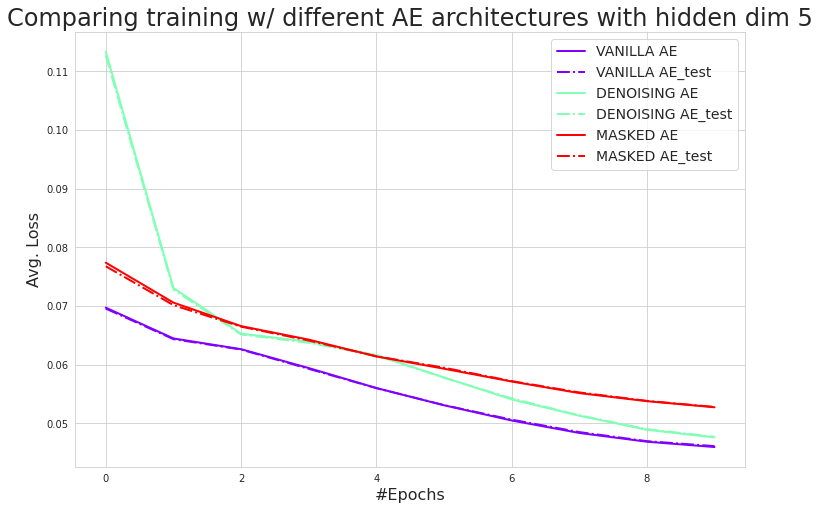

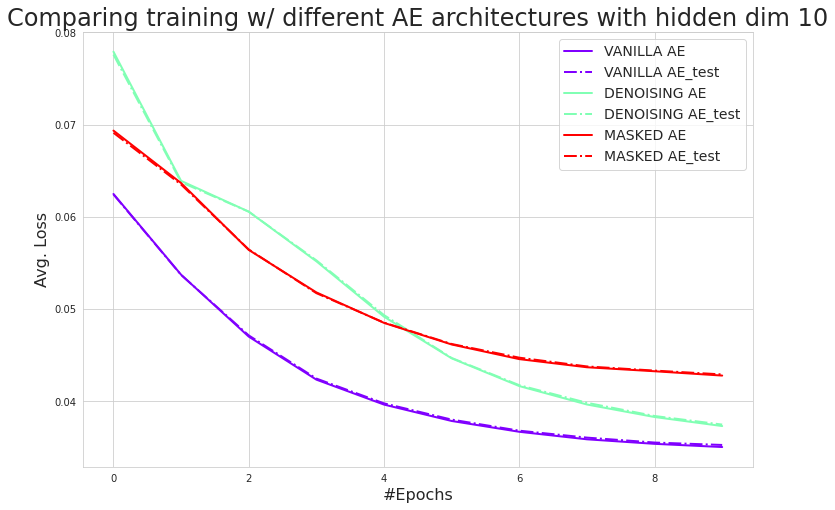

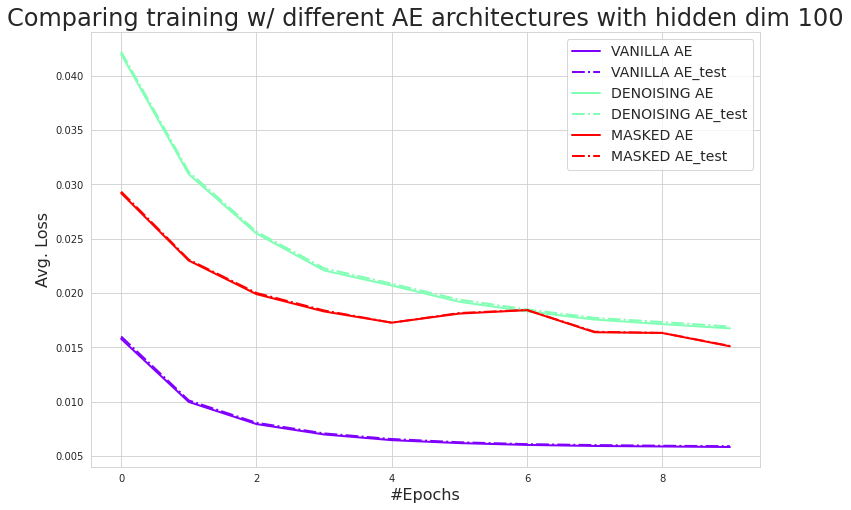

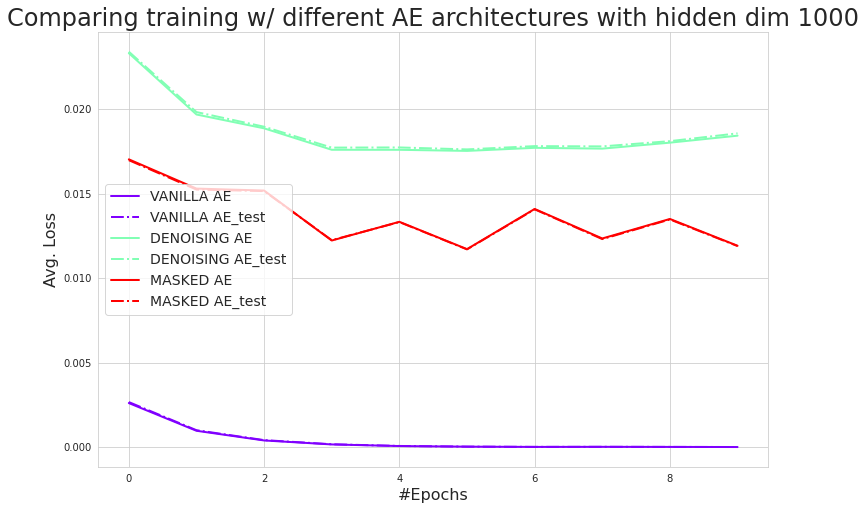

In [ ]:
MODELS = {
    "VANILLA AE": Autoencoder,
    "DENOISING AE": DenoisingAutoencoder,
    "MASKED AE": MaskedAutoencoder,
}

NUM_REPEATS = 3
NUM_EPOCHS = 10
BATCH_SIZE = 200

##########################################
####### TODO : define model architecture 
# hidden dims is a list of ints
INPUT_DIMS = 784
NUM_CLASSES = 10
ACTIVATION = nn.Identity()
HIDDEN_DIMS_LIST = [[5],[10], [100], [1000]]
##########################################

# load and create MNIST dataset
dataset = MNIST(BATCH_SIZE, [0.6, 0.4])
for HIDDEN_DIMS in HIDDEN_DIMS_LIST:
# logging metrics
    feats_dim = HIDDEN_DIMS[-1]
    train_losses, test_losses = {}, {}
    accuracy = {}

    # run experiment w/ different models
    for model_idx, model_cls in MODELS.items():
        _train_loss, _valid_loss, _acc = [], [], []
        for expid in range(NUM_REPEATS):
            print("run : {},  model : {}".format(expid, model_idx))
            model = model_cls(INPUT_DIMS, HIDDEN_DIMS, activation=ACTIVATION)
            experiment = Experiment(dataset, model, num_classes=NUM_CLASSES)
            train_stats = experiment.train(num_epochs=NUM_EPOCHS)
            eval_stats = experiment.evaluate_w_linear_probe(feats_dim, NUM_EPOCHS)
            _train_loss.append(train_stats["train_losses"])
            _valid_loss.append(train_stats["valid_losses"])
            _acc.append(eval_stats["accuracy"])
        
        train_losses[model_idx] = np.mean(_train_loss, axis=0)
        test_losses[model_idx] = np.mean(_valid_loss, axis=0)
        accuracy[model_idx] = np.mean(_acc)

    # plot losses
    plotter(train_losses, test_losses, HIDDEN_DIMS)

    # report accuracy
    for model_idx, acc in accuracy.items():
        print("Model : {}, Accuracy : {}".format(model_idx, acc))

## Nonlinear dimensionality reduction on MNIST

Train a nonlinear autoencoder with different bottleneck sizes e.g. (5, 10, 100, 1000) and report performance of your choice of architecture on the MNIST dataset.

